# Estudio de la propagación de los estadísticos

Se analiza cómo evolucionan la media y la covarianza de un proceso estocástico generado a partir de un sistema descripto por una ecuación estocástica en diferencias.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.signal import csd, welch

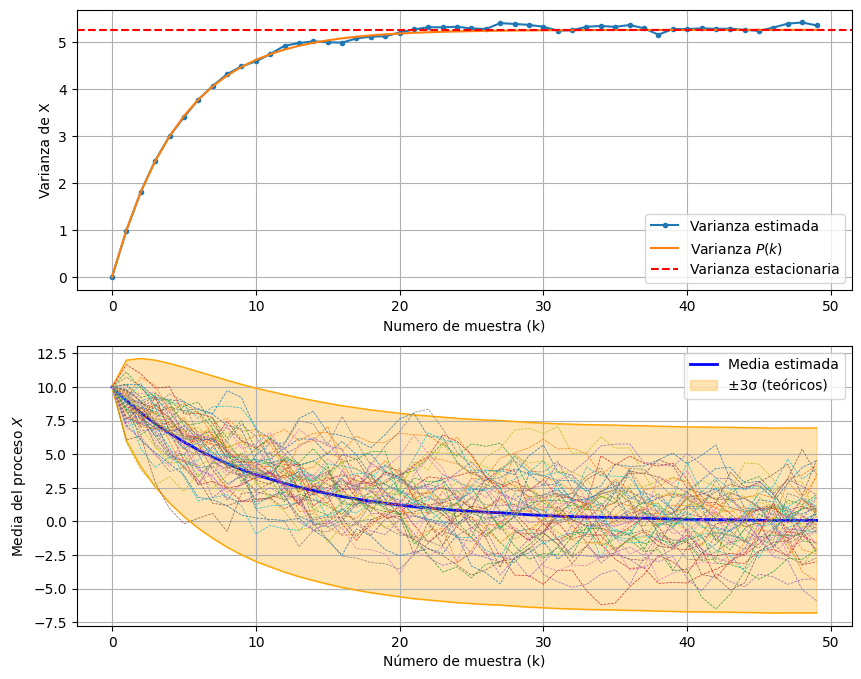

In [59]:
# Parámetros del sistema
m0 = 10
a = 0.9
sigma_e = 1.0
N_samples = 50     # Número de pasos de tiempo por realización
N_realizations = 10000   # Número de realizaciones

# Resolución del sistema estocástico
e = sigma_e * np.random.randn(N_samples, N_realizations)
x = np.zeros_like(e)
x[0,:] = m0
for ir in range(N_realizations):
    for k in range(1, N_samples):
        x[k,ir] = a * x[k-1,ir] + e[k-1,ir]

# Media y varianza del proceso
mean_x = np.mean(x, axis=1)
var_x = np.var(x, axis=1)

# Cálculo de varianza teórica
P = np.zeros(N_samples)
for k in range(1, N_samples):
    P[k] = a**2 * P[k-1] + sigma_e**2

# Varianza estacionaria teórica
P_inf = sigma_e**2 / (1 - a**2)


# Gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(var_x, '.-', label='Varianza estimada')
ax1.plot(P, '-', label='Varianza $P(k)$')
ax1.axhline(P_inf, color='r', linestyle='--', label='Varianza estacionaria')
ax1.grid()
ax1.legend()
ax1.set_xlabel("Numero de muestra (k)")
ax1.set_ylabel("Varianza de X")

# Cálculo de ±3 sigma (raíz de la varianza teórica en cada k)
std_dev = np.sqrt(P)
upper_band = mean_x + 3 * std_dev
lower_band = mean_x - 3 * std_dev

# Gráfico de la media y las bandas ±3 sigma
ax2.plot(mean_x, linewidth=2,  label='Media estimada', color='blue')
ax2.fill_between(range(N_samples), lower_band, upper_band, color='orange', alpha=0.3, label='±3σ (teóricos)')
ax2.plot(lower_band, linewidth=1,  color='orange')
ax2.plot(upper_band, linewidth=1,  color='orange')

for ir in range(50):
    ax2.plot(x[:,ir],'--',linewidth=0.5)

ax2.grid()
ax2.legend()
ax2.set_xlabel("Número de muestra (k)")
ax2.set_ylabel("Media del proceso $X$")

plt.show()


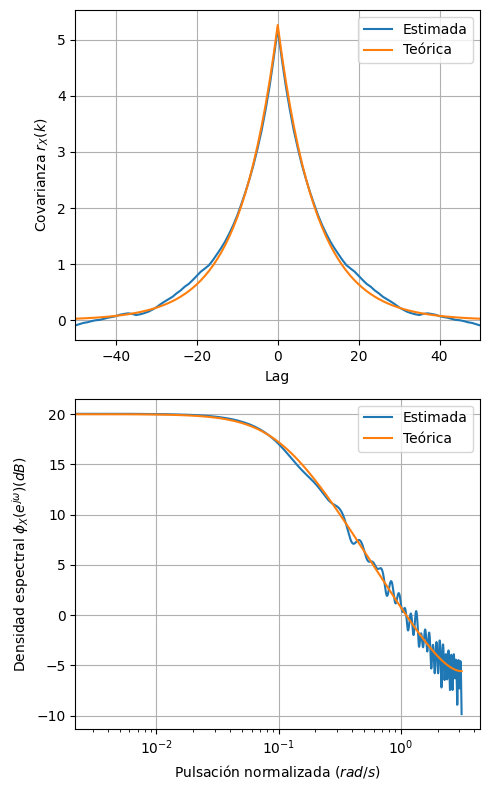

In [ ]:
# Covarianza teórica
N = 1024
k = np.arange(0,N,1)
rx = a**k * sigma_e**2 / (1 - a**2)
rx_full = np.concatenate((rx[::-1], rx[1:]))  # Espejo sin duplicar el 0
N_full = len(rx_full)  # 2N - 1
k_full = k_full = np.arange(-len(rx)+1, len(rx))

# Densidad espectral de potencia obtenida por DFT a partir de la teórica 
Sx_teo = np.fft.fftshift(np.fft.fft(rx_full))
Sx_teo = np.abs(Sx_teo) 
w = np.fft.fftshift(np.fft.fftfreq(N_full, d=1)) * 2 * np.pi  # Frecuencia en radianes


# Covarianza estimada
# Vamos con una única realización. Ya se que es estacionario y ergódico
N_samples = 100000   # Muestras totales en la realización
N = 10000            # Muestras a utilizar para el cálculo de la covarianza (luego de que los transitorios desaparecen)
e = np.random.normal(0,sigma_e,N_samples)
# Otra forma de implementar el filtro (mucho más directa)
x = lfilter([1], [1, -a], e)
x_st = x[-N:]

# Autocovarianza estimada
lags = np.arange(-50, 51)
rx_est = np.correlate(x_st - np.mean(x_st), x_st - np.mean(x_st), mode='full') / N
rx_est = rx_est[N+lags-1]  # centrado en lag 0

# Zero-padding para igualar longitud
rx_est_padded = np.zeros(N_full)
center = N_full // 2
rx_est_padded[center - 50:center + 51] = rx_est

# Espectro (por DFT)
Sx_est = np.fft.fftshift(np.fft.fft(rx_est_padded))
Sx_est = np.abs(Sx_est)

#f, Sx_est = welch(x_st, fs=1)
#w, Sx = welch(x_st, fs=1)
#Sx = np.abs(Sx)

# Gráfica
fig, (ax1, ax2) = plt.subplots( 2, 1, figsize=(5, 8))
ax1.plot(lags,rx_est,label='Estimada')
ax1.plot(k_full,rx_full,label="Teórica")
ax1.set_xlabel("Lag")
ax1.set_ylabel("Covarianza $r_X(k)$")
ax1.set_xlim(lags[0],lags[-1])
ax1.grid()
ax1.legend()

ax2.plot(w, 10*np.log10(Sx_est), label='Estimada')
ax2.plot(w, 10*np.log10(Sx_teo), label='Teórica')
ax2.grid()
ax2.set_xlabel("Pulsación normalizada ($rad/s$)")
ax2.set_ylabel("Densidad espectral $\phi_X(e^{jω}) (dB)$")
ax2.semilogx()
ax2.legend()
plt.tight_layout()
plt.show()